# Data preparation and parametric analysis

### Importing libraries

In [8]:
import os
import glob
import math
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import pingouin as pg
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison
from xlsxwriter import Workbook
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_1samp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.font_manager as fm
from sklearn.linear_model import LinearRegression

#and directories

os.chdir('C:\\Users\\bianc\\OneDrive - Universitat de Barcelona\\GitHub\\beat-perception-speech\\Data')

directory = os.getcwd()   
input= 'C:\\Users\\bianc\\OneDrive - Universitat de Barcelona\\GitHub\\beat-perception-speech\\Data\\single_participants_data\\'
output= 'C:\\Users\\bianc\\OneDrive - Universitat de Barcelona\\GitHub\\beat-perception-speech\\Analysis\\output_analysis\\'

dataframes_R_analysis= 'C:\\Users\\bianc\\OneDrive - Universitat de Barcelona\\GitHub\\beat-perception-speech\\Analysis\\data_analysis_R\\'

### Functions

In [2]:

#function to get count of hits fa and misses in Online 
def catch_count_group(dataframe):
    out=[0,0,0]
    for _, row in dataframe.iterrows():
        p = row['catch_syll_resp']
        if p != '-':
            if 'catch' in p:
                out[0] += 1
            if 'miss' in p:
                out[1] += 1
            if 'false alarm' in p:
               out[2] += 1 
    out=np.array(out)
    out= out.reshape(1,3)
    catch= pd.DataFrame(out, columns=['catch', 'miss', 'fa'])
    return catch


# I will get the value for each condition and for each subject, with these values I will calcluate which participant scored below the fifth percentile. 

def accuracy_rts(df): #I will put the catches_tot
    accur_rts=[]
    for i in range(len(df)):
        hit= df['catch'].iloc[i,]
        miss= df['miss'].iloc[i,]
        acc= hit/ (hit+miss)
        accur_rts.append(acc)
    df['accuracy_rts']= accur_rts
    return df, accur_rts

#Percentile outlier detection

def outlier_perc(df, quantile ): #in df will also be present the column with percentiles
    outs=[]
    # Calculate the 5th percentile value
    percentile_threshold = df['accuracy_rts'].quantile(quantile)
    for i in range(len(df)):
        block= df['accuracy_rts'].iloc[i]
        if block > percentile_threshold:
            out= 'ok'
            outs.append(out) 
        if block <= percentile_threshold:
            out= 'outlier'
            outs.append(out)
    df['outlier_percentiles']= outs
    return df, percentile_threshold
        

# Function that gives te values 1,2,3,4 given to the target in the experiment to the actula A,C,X syllable target

def rename_sylls(df):
    merged=[]
    for i in range(len(df)):
        catch= df['syll_to_catch'].iloc[i]
        if catch == 1:
            l= 'A'
            merged.append(l)
        if catch == 2:
            l= 'C'
            merged.append(l)
        if catch==3: 
            l= 'x1'
            merged.append(l)
        if catch == 4:
            l= 'x2'
            merged.append(l)           
    df['syll_to_catch2']= merged
    return df


# Accuracy as 1 or 0 based on the keyboard keys

def accuracy(dataframe,namecol,pos):
    accry=[]
    for i in range(len(dataframe)):
        p= dataframe.test_offline.iloc[i,]
        if 'viol' not in p:
            if dataframe['Partz_no_partm.keys'].iloc[i,]=='z':
                l=1
                accry.append(l)
            if dataframe['Partz_no_partm.keys'].iloc[i,]=='m':
                k=0
                accry.append(k)
        if 'viol' in p:
            if dataframe['Partz_no_partm.keys'].iloc[i,]=='z':
                u=0
                accry.append(u)
            if dataframe['Partz_no_partm.keys'].iloc[i,]=='m':
                t=1
                accry.append(t)
    dataframe.insert(pos,namecol,accry)
    return dataframe



#rename the condtions, originally had a different name 


def rename_cond(DATA, condition_var):
    rename_map = {
        'what': 'R',
        'when': 'B',
        'conjunction_un': 'RB+',
        'conjunction_syn': 'RB-'
    }
    DATA[condition_var] = DATA[condition_var].replace(rename_map)
    return DATA




#add in the dataframes the parameetric variable of informativeness index hypothesized 
def info_index(df, name):
    idx=[]
    for i in range(len(df)):
        cond= df[name].iloc[i]
        if cond == 'B':
            info= 1
            idx.append(info)
        if cond == 'R':
            info=2
            idx.append(info)
        if cond == 'RB-':
            info=3
            idx.append(info)
        if cond == 'RB+':
            info=4
            idx.append(info)
    df['info_index']=idx
    return df

# Store in which position in the sequence the target syllable was positioned

def syllable_order (df, name):
    pos=[]
    times= ['0.0', '0.222', '0.444', '0.666', '0.888', '1.11', '1.332', '1.554','1.776', '1.998']
    idx= [1,2,3,4,5,6,7,8,9,10]
    for i in range(len(df)):
        time_target= df[name].iloc[i]
        if time_target in times:
            pos.append(idx[times.index(time_target)])
        else:
            pos.append(None)  
    df['order_syll_seq2']=pos
    return df

# group the confidence rating score

def security_rating_grouped(df):
    new_sec=[]
    for i in range(len(df)):
        sec_rate= df['security_1_7.keys'].iloc[i]
        if sec_rate < 3:
            new= 'Unsecure'
        if 3 <= sec_rate <= 5:
            new= 'Uncertain'
        if  sec_rate >5:
            new= 'Secure'

        new_sec.append(new)
    df['sec_rate_merged']= new_sec
    return df


#get partial eta swquared for effect size of 2x2 anova
def partial_eta_sq(aov, effect):
    row = aov[aov['Source'] == effect].iloc[0]
    SS_effect = row['SS']
    df_effect = row['ddof1']
    df_error  = row['ddof2']
    F_value   = row['F']
    MS_effect = SS_effect / df_effect
    MS_error = MS_effect / F_value
    SS_error = MS_error * df_error

    return SS_effect / (SS_effect + SS_error)



## Import data

In [3]:
# import the data that was preprocessed based on pavlovia output (which is extremely disorganized)

files= glob.glob(input+'*.csv')


frames=[]


for i in range(len(files)):
    data= pd.read_csv(files[i], header= 0)
    bmrq= data[['BMRQ_Score']]
    bil=data[['bilingual']]
    if files[i]== input + "part_s103.csv":
        data['participant']= 's103' #this to correct some participants who erroneously inserted the same id
    if files[i]==input + "part_s193.csv":
        data['participant']= 's193'
    data2= data.iloc[:,:55]
    data2['n_lang']= data['n_lang']
    data2['n_lang_used']=data['n_lang_used']
    data2['partiture']=data['partiture']
    data2['tendence_mix_lan']= data['tendence_mix_lan']
    data2['music_use']=data['muisc_use']
    data2['bilingual']= bil
    data2['ability_learn_l2']= data['ability_learn_l2']
    data2['music_exp']= data['music_experience']
    data2['mus_exp_age']=data['age_M1']
    data2['BMRQ_score']= bmrq
    
    data2['OrdinalIndex'] = data2.reset_index().index
    frames.append(data2)


DATA= pd.concat(frames)
f=DATA['participant'].unique().tolist()
len(f)


# exclude subjects that have deficits, in the experiment sel report over auditory/language deficits

subjects_to_exclude= []
for i in range(len(DATA)):
    if i > 0:
        lang_def= DATA['lang_deficit'].iloc[i]
        aud_def= DATA['aud_deficit'].iloc[i]
        if lang_def == 'yes'  or aud_def == 'yes':
            if DATA['participant'].iloc[i] != DATA['participant'].iloc[i-1] or i == 1:
                subjects_to_exclude.append(DATA['participant'].iloc[i])

print('SUBJECTS EXCLUDED DUE TO LANGUAGE OR AUDITORY IMPAIRMENTS:')
print(subjects_to_exclude)

#exclude them

DATA = DATA[~DATA['participant'].isin(subjects_to_exclude)]



DATA=rename_cond(DATA, 'condition')

# age fix (it was not in proper integers)

age_clean = DATA['age'].astype(str).str.strip().str.lower()
age_clean = age_clean.replace(
    ['unknown', 'n/a', 'na', 'missing', 'nan', 'none', 'null', ''], np.nan
)
age_numeric = age_clean.str.extract(r'(\d+\.?\d*)')[0]
age_numeric = pd.to_numeric(age_numeric, errors='coerce')
DATA['age'] = age_numeric

#n_lang fix (it was not in proper integers)

nlang_clean = DATA['n_lang'].astype(str).str.strip().str.lower()
nlang_clean = nlang_clean.replace(
    ['unknown', 'n/a', 'na', 'missing', 'nan', 'none', 'null', ''], np.nan
)
nlang_numeric = nlang_clean.str.extract(r'(\d+\.?\d*)')[0]
nlang_numeric = pd.to_numeric(nlang_numeric, errors='coerce')
DATA['n_lang'] = nlang_numeric

#n_lang used (it was not in proper integers)

DATA.loc[DATA['n_lang_used'] == "2 o 3", 'n_lang_used'] = '3'

nlang_cleanu = DATA['n_lang_used'].astype(str).str.strip().str.lower()
nlang_cleanu = nlang_cleanu.replace(
    ['unknown', 'n/a', 'na', 'missing', 'nan', 'none', 'null', ''], np.nan
)
nlang_numericu = nlang_cleanu.str.extract(r'(\d+\.?\d*)')[0]
nlang_numericu = pd.to_numeric(nlang_numericu, errors='coerce')
DATA['n_lang_used'] = nlang_numericu


f=DATA['participant'].unique().tolist()

print('Total number of participants (excluded those with language/auditory deficits): '+ str(len(f)))

SUBJECTS EXCLUDED DUE TO LANGUAGE OR AUDITORY IMPAIRMENTS:
['s1', 's127', 's29', 's4']
Total number of participants (excluded those with language/auditory deficits): 147


### Demographic charachteristics of the sample and summary of in-house questionnaire

In [4]:


#Sex

Gender= DATA.groupby(['participant'])[ 'sex'].unique().reset_index()
females= Gender[Gender['sex'] == 'feminino']
males=Gender[Gender['sex'] == 'masculino']


print("Number females:"+ str(len(females)))
print("Number males:"+ str(len(males)))

#Age
Age= DATA.groupby(['participant'])[ 'age'].unique().reset_index()
Ages=[]
for i in range(len(Age)):
    agei= Age['age'].iloc[i]
    Ages.append(int(agei[0]))

print("Mean age: " + str(np.mean(Ages)))

print( "standard deviation of Age:" + str(np.std(Ages)))

#scholarity level

sch_lev=DATA.groupby(['education_level'])['participant'].nunique().reset_index()

print(sch_lev)

#Handadness

hand= DATA.groupby(['participant'])[ 'hand'].unique().reset_index()
right= hand[hand['hand'] == 'right']
left=hand[hand['hand'] == 'left']


print("Number Right:"+ str(len(right)))
print("Number left:"+ str(len(left)))


#Bilinguials
print('LANGUAGE RELATED')


bil= DATA.groupby(['participant'])['bilingual'].unique().reset_index()
n_bilingual = bil[bil['bilingual'] == 'yes']['participant'].nunique()

print("N_bilinguals"+ str(n_bilingual))

# avarge number of language spoken

lang_sp=  DATA.groupby(['participant'])['n_lang'].unique().reset_index()
lang_sp.iloc[80,1]= [3.0]
lang_sp.iloc[88,1]= [3.0] #participants put 2 or 3

lang_n=[]
for i in range(len(lang_sp)):
    langi= lang_sp['n_lang'].iloc[i]
    lang_n.append(int(langi[0]))

print("Mean number language spoken: " + str(np.mean(lang_n)))

print( "standard deviation of languages spoken:" + str(np.std(lang_n)))

# avarage number of langauges used

lang_us=  DATA.groupby(['participant'])['n_lang_used'].unique().reset_index()
lang_nu=[]
for i in range(len(lang_us)):
    langu= lang_us['n_lang_used'].iloc[i]
    lang_nu.append(int(langu[0]))

print("Mean number languages used daily: " + str(np.mean(lang_nu)))

print( "standard deviation of languages used daily:" + str(np.std(lang_nu)))


# tendency to mix languages
mix_lang=  DATA.groupby(['participant'])['tendence_mix_lan'].unique().reset_index()

mix_lang_n=[]
for i in range(len(mix_lang)):
    mix= mix_lang['tendence_mix_lan'].iloc[i]
    mix_lang_n.append(int(mix[0]))

print("Mean tendency to mix laguages: " + str(np.mean(mix_lang_n)))

print( "standard deviation to mix languages:" + str(np.std(mix_lang_n)))


# Ability to learn L2

lang2=  DATA.groupby(['participant'])['ability_learn_l2'].unique().reset_index()

lang_new=[]
for i in range(len(mix_lang)):
    l2= lang2['ability_learn_l2'].iloc[i]
    lang_new.append(int(l2[0]))

print("Mean ability to learn a new langauge: " + str(np.mean(lang_new)))

print( "SD ability learn l2:" + str(np.std(lang_new)))

print('MUISC RELATED')

# Music players

mus=DATA.groupby(['participant'])['music_exp'].unique().reset_index()
n_mus_exp=mus[mus['music_exp']=='yes']['participant'].nunique()

print('N music experience:'+str(n_mus_exp) )

#no music experience
n_mus_expN=mus[mus['music_exp']=='no']['participant'].nunique()

print('N NO music experience:'+str(n_mus_expN) )


mus_yes=DATA[DATA['music_exp']=='yes']
mus_age= mus_yes.groupby(['participant'])['mus_exp_age'].unique().reset_index()

Age_start_music=[]
for i in range(len(mus_age)):
    agei= mus_age['mus_exp_age'].iloc[i]
    if pd.isna(agei):
        continue
    Age_start_music.append(int(agei[0]))


print("Mean age music: " + str(np.mean(Age_start_music)))

print( "standard deviation of Age music:" + str(np.std(Age_start_music)))

# Counts of those that currently play an instrument

mus_daily=DATA.groupby(['participant'])['music_use'].unique().reset_index()

n_mus_day_yes=mus_daily[mus_daily['music_use']=='yes']['participant'].nunique()

print('N music experience NOW:'+str(n_mus_day_yes) )

# Counts of those that know partiture

partiture=DATA.groupby(['participant'])['partiture'].unique().reset_index()

partiture_yes=partiture[partiture['partiture']=='yes']['participant'].nunique()

print('N of those that know partiture:'+str(partiture_yes) )

# BMRQ SCORE

bmrq=  DATA.groupby(['participant'])['BMRQ_score'].unique().reset_index()

bmrw_n=[]
for i in range(len(bmrq)):
    bm= bmrq['BMRQ_score'].iloc[i]
    bmrw_n.append(int(bm[0]))

print("MEAN BMRQ: " + str(np.mean(bmrw_n)))

print( "SD BMRQ:" + str(np.std(bmrw_n)))

#Number of participants for all pilots

n_part_byexp= DATA.groupby(['expName', 'condition'])['participant'].nunique().reset_index()

print(n_part_byexp)

Number females:100
Number males:47
Mean age: 23.41496598639456
standard deviation of Age:4.304472499882469
   education_level  participant
0  Bachelor degree           57
1        Doctorate            6
2    Master degree           31
3            Other            2
4        Secondary            1
5  Upper secondary           50
Number Right:130
Number left:15
LANGUAGE RELATED
N_bilinguals146
Mean number language spoken: 3.251700680272109
standard deviation of languages spoken:0.8716513174723238
Mean number languages used daily: 2.3741496598639458
standard deviation of languages used daily:0.6516424497865604
Mean tendency to mix laguages: 3.2789115646258504
standard deviation to mix languages:1.3339232347705834
Mean ability to learn a new langauge: 3.7346938775510203
SD ability learn l2:1.012349127835443
MUISC RELATED
N music experience:102
N NO music experience:45
Mean age music: 9.386138613861386
standard deviation of Age music:3.7626888874785434
N music experience NOW:27
N of those 

### Clean Data :  Exclusion of 5th percentile based on hit accuracy in implicit learning test


C:\Users\bianc\AppData\Local\Temp\ipykernel_6812\2658019034.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  catches = DATA.groupby(['participant', 'condition', 'syll_to_catch']).apply(catch_count_group).reset_index()


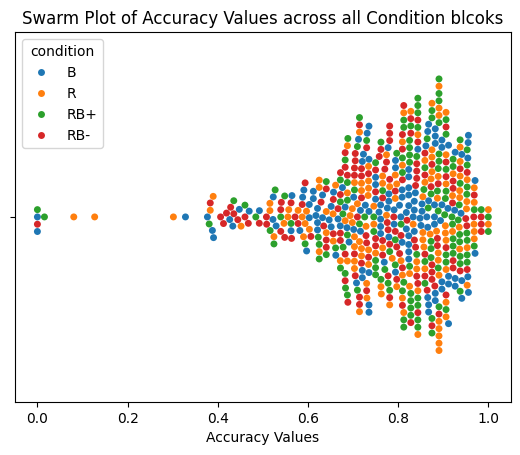

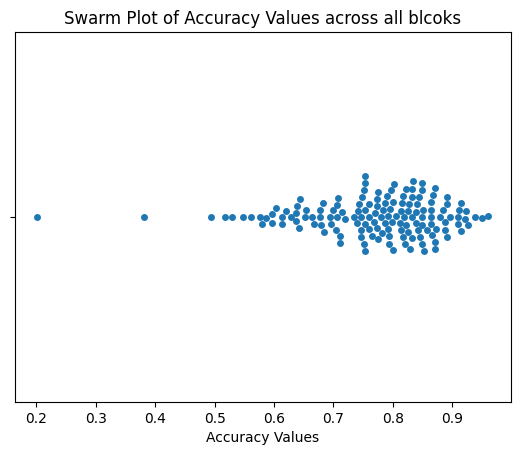

C:\Users\bianc\AppData\Local\Temp\ipykernel_6812\2658019034.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g= sns.swarmplot(data= catches_toexclude, x= 'condition', y= 'participant', palette=custom_palette, size= 10)


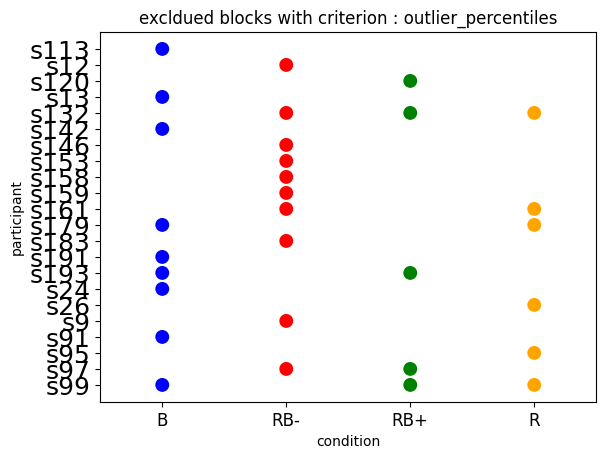

THRESHOLD OF 5TH CENTILE
0.46842619745845554


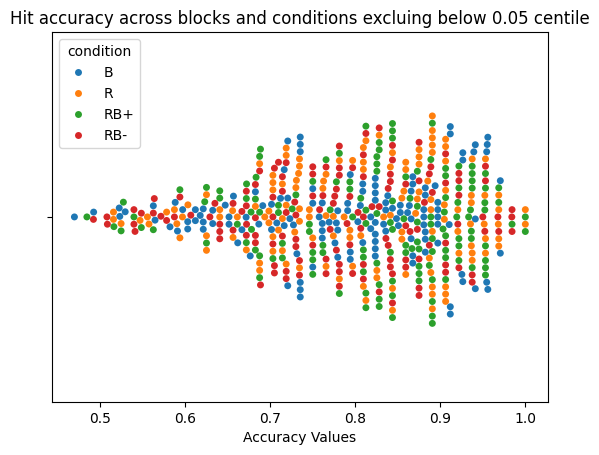

CRITERION: 0.05 CENTILE SELECTED:
    participant condition  catch  miss  fa  accuracy_rts outlier_percentiles
68         s113         B     25    39  12      0.390625             outlier
99          s12       RB-     26    37  11      0.412698             outlier
102        s120       RB+     24    39   4      0.380952             outlier
136         s13         B     30    37   7      0.447761             outlier
149        s132         R     28    34  14      0.451613             outlier
150        s132       RB+     29    34   6      0.460317             outlier
151        s132       RB-     29    33  11      0.467742             outlier
188        s142         B     26    41  19      0.388060             outlier
207        s146       RB-     29    34  19      0.460317             outlier
239        s153       RB-     28    35   4      0.444444             outlier
251        s158       RB-     27    35   8      0.435484             outlier
255        s159       RB-     26    38   2

16

In [ ]:
#the percentile method was selected as data is not normally dsitrivuted

catches = DATA.groupby(['participant', 'condition', 'syll_to_catch']).apply(catch_count_group).reset_index()

#extract the total for each participant

catches_tot= catches.groupby(['participant', 'condition'])[['catch','miss','fa']].sum().reset_index()

#calculate the accuracy and set it as a new variable with accuracy_rts

catches_tot, acc_all= accuracy_rts(catches_tot)

# visualize the values

sns.swarmplot(x= "accuracy_rts", data= catches_tot, hue= "condition")
plt.xlabel("Accuracy Values")
plt.title("Swarm Plot of Accuracy Values across all Condition blcoks")
plt.show()

#visualize the total for the 

catches_tot_all= catches.groupby(['participant'])[['catch','miss','fa']].sum().reset_index()

#calculate the accuracy and set it as a new variable with accuracy_rts

catches_tot_all, acc_all_all= accuracy_rts(catches_tot_all)


# visualize the values

sns.swarmplot(x=acc_all_all)
plt.xlabel("Accuracy Values")
plt.title("Swarm Plot of Accuracy Values across all blcoks")
plt.show()


catches_tot, centile= outlier_perc(catches_tot, 0.05)


#now ectract the outliers and visualize them 


catches_toexclude= catches_tot[catches_tot['outlier_percentiles']=='outlier']

custom_palette = {'B': 'blue', 'R': 'orange', 'RB-': 'red', 'RB+': 'green'}
# Visualize number of cathces by condition and by letter

g= sns.swarmplot(data= catches_toexclude, x= 'condition', y= 'participant', palette=custom_palette, size= 10)

# Set custom x-axis tick labels

plt.title('excldued blocks with criterion : '+str('outlier_percentiles'))

plt.xticks(fontsize=12) 
#plt.set(xticklabels = labels)
plt.yticks(fontsize=18) 

plt.show()


print("THRESHOLD OF 5TH CENTILE")
print(centile)

    

#VISUALIZATION

# Identify common rows using pd.merge
common_rows = pd.merge(catches, catches_toexclude, on=['participant', 'condition'], how='inner')

# Drop common rows from RTs
# Re-index both for common columns

catches.set_index(['participant','condition'], inplace=True)
common_rows.set_index(['participant', 'condition'], inplace=True)

catches_clean= catches.drop(common_rows.index).reset_index()

#visualize again the swarmplot without the outliers
acc2= catches_tot[catches_tot['outlier_percentiles']== 'ok']

sns.swarmplot(x= "accuracy_rts", data= acc2, hue= "condition")
plt.xlabel("Accuracy Values")
plt.title("Hit accuracy across blocks and conditions excluing below 0.05 centile")
plt.show()


print('CRITERION: 0.05 CENTILE SELECTED:')

print(catches_toexclude)

f=catches_toexclude['participant'].unique().tolist()
len(f)

# Exclude the participants with 2 or more blocks where hit rate is below 5th centile

list_part_exclude = catches_toexclude['participant'].value_counts()
list_part_exclude = list_part_exclude[list_part_exclude >= 2].index.tolist()


print('EXCLUDED PARTICIPANTS (2 or more blocks below 5th centile)')
print(list_part_exclude)

len(list_part_exclude)

#clean DATA from those in list_part_exclude

DATA = DATA.loc[~DATA['participant'].apply(lambda x: x in list_part_exclude)]

# Update the catches to exclude only with those that show only one block not reaching the cutoff for further cleaning

part_to_exclude= catches_toexclude[catches_toexclude['participant'].isin(list_part_exclude)]

common_rows= pd.merge(part_to_exclude, catches_toexclude, on=['participant', 'condition'], how='inner')

#it is important if I want to do this they must be indexed based on the common values 

catches_toexclude.set_index(['participant','condition'], inplace=True)
common_rows.set_index(['participant', 'condition'], inplace=True)
# Drop common rows from RTs th

catches_toexclude= catches_toexclude.drop(common_rows.index).reset_index()

print('UPDATED CATCHES TO EXCLUDE:')
print(catches_toexclude)

#save the one cleaned frm the excluded

#store the fifth pèrcentile catches to excllude

catches_toexclude['accuracy_rts']= round(catches_toexclude['accuracy_rts'],3)

cateches_save= catches_toexclude[['participant', 'condition', 'catch', 'miss', 'accuracy_rts']]

# Save a .csv of the excluded blocks

cateches_save.to_csv(output+'excluded_blocks_0.05_perc.csv')

f=cateches_save['participant'].unique().tolist()
len(f)
#0.46959921798631477


## 1. EXPLICIT LEARNING: Recongition of sequence test

### Dataframe preparation and save for R models analysis

In [9]:
# Find the index of 'test_offline'
start_index = DATA.columns.get_loc('test_offline')

# Select all columns from 'test_offline' onward
selected_columns = DATA.columns[start_index:len(DATA.columns)-3].tolist() #take out the music age cuz those not musician are nans and later i drop all nans

# Explicitly include 'ExpName' by creating a new list that ensures it's added
selected_columns = ['expName'] + selected_columns  # Prepends 'ExpName' to the list of columns

# Create the new DataFrame including 'ExpName'
DATA_off = DATA[selected_columns]


DATA_off=rename_cond(DATA_off, 'condition_off')

DATA_off['participant']= DATA['participant']

DATA_off['BMRQ_score']=DATA['BMRQ_score']

f=DATA_off['participant'].unique().tolist()

DATA_off['age']= DATA['age']
DATA_off['sex']= DATA['sex']
DATA_off['hand']=DATA['hand'] 
DATA_off['group']= DATA['group']
f=DATA_off['participant'].unique().tolist()

DATA_off['education_level']= DATA['education_level']

DATA_off=DATA_off.dropna(how='any') #any rows with nans dropped

#add the music experience 

# Add mus_exp_age AFTER cleaning
mus_age_df = DATA[['participant', 'mus_exp_age']].drop_duplicates()
DATA_off = pd.merge(DATA_off, mus_age_df, on='participant', how='left')


# exclude the blocks below 5th percentile

catches_toexclude1=catches_toexclude.rename(columns={'condition': 'condition_off'})

common_rows = pd.merge(DATA_off, catches_toexclude1, on=['participant', 'condition_off'], how='inner')

DATA_off.set_index(['participant','condition_off'], inplace=True)
common_rows.set_index(['participant', 'condition_off'], inplace=True)
# Drop common rows from RTs th

DATA_off= DATA_off.drop(common_rows.index).reset_index()

DATA_off= DATA_off.drop('accuracy', axis= 'columns')

DATA_off= accuracy(DATA_off, 'accuracy', 12)


#rename the conditions

DATA_off= rename_cond(DATA_off, 'condition_off')

DATA_off= info_index(DATA_off, 'condition_off')

# add the recoded secuirty lvevel merged

DATA_off= security_rating_grouped(DATA_off)

sec_order = ['Unsecure', 'Uncertain', 'Secure']

# Reorder levels of 'condition_off' in acc_tot2
DATA_off['sec_rate_merged'] = pd.Categorical(DATA_off['sec_rate_merged'], categories=sec_order, ordered=True)


DATA_off['participant'] = DATA_off['participant'].astype(str)


DATA_off.to_csv(dataframes_R_analysis+'ExplicitTestData.csv') 


n_part_byexp_clean= DATA_off.groupby(['expName', 'condition_off'])['participant'].nunique().reset_index()

print( n_part_byexp_clean)

f=DATA_off['participant'].unique().tolist()
print(len(f))


C:\Users\bianc\AppData\Local\Temp\ipykernel_6812\2344573198.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA[condition_var] = DATA[condition_var].replace(rename_map)
C:\Users\bianc\AppData\Local\Temp\ipykernel_6812\414938993.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA_off['participant']= DATA['participant']
C:\Users\bianc\AppData\Local\Temp\ipykernel_6812\414938993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

                expName condition_off  participant
0       Experiment4_uns             B           34
1       Experiment4_uns             R           34
2       Experiment4_uns           RB+           34
3       Experiment4_uns           RB-           30
4         Unsyncopated1             B           35
5         Unsyncopated1             R           36
6         Unsyncopated1           RB+           37
7         Unsyncopated1           RB-           35
8   Unsyncopated_study2             B           35
9   Unsyncopated_study2             R           37
10  Unsyncopated_study2           RB+           38
11  Unsyncopated_study2           RB-           38
12  Unsyncopated_study3             B           31
13  Unsyncopated_study3             R           32
14  Unsyncopated_study3           RB+           31
15  Unsyncopated_study3           RB-           31
141


### 1.1 Accuracy

#### T-test accuracy against chance 

In [ ]:
# some stats, accuracy against 0.5

def ttest2(df, iv, dv, target_mean):
    conds= ['B','R', 'RB-', 'RB+']
    for k in range(len(conds)):
        dfk= df[df[iv] == conds[k]]
        dfkval= list(dfk[dv])
        df_degrees = len(dfkval) - 1  
        t_test, pvalue= stats.ttest_1samp(dfkval, popmean= target_mean)
        dgf= stats.t.interval(0.95, len(df)-1, loc=np.mean(dfkval), scale=stats.sem(dfkval))
        #print(name+': T:'+str(round(t_test),4)+'p-value:'+ str(round(pvalue),4)+'CF:'+ str(tuple(round(val, 4) for val in dgf)))
        # Calculate the mean and standard deviation of the sample
        sample_mean = np.mean(dfkval)
        sample_std = np.std(dfkval, ddof=1)  # using ddof=1 to get the sample standard deviation
# Calculate Cohen's d for effect size
        cohen_d = (sample_mean - 0) / sample_std
        print(conds[k] + ': T:' + str(round(t_test, 4)) + '; df=' + str(df_degrees)+ ', p-value:' + str(round(pvalue, 4)) + ' CF:' + str(tuple(round(val, 4) for val in dgf))+f" Cohen's d = {cohen_d}")


mean_acc_rule = DATA_off.groupby(['participant','condition_off'])[['accuracy']].mean().reset_index()
ttest2(mean_acc_rule, 'condition_off', 'accuracy',0.5)



B: T:1.5331; df=134, p-value:0.1276 CF:(np.float64(0.4964), np.float64(0.5296)) Cohen's d = 5.221447866488588
R: T:3.2795; df=138, p-value:0.0013 CF:(np.float64(0.5108), np.float64(0.5431)) Cohen's d = 5.433406436451499
RB-: T:4.1765; df=133, p-value:0.0001 CF:(np.float64(0.5201), np.float64(0.5558)) Cohen's d = 5.116165127651417
RB+: T:3.9708; df=139, p-value:0.0001 CF:(np.float64(0.5164), np.float64(0.5485)) Cohen's d = 5.5080707657760435


C:\Users\bianca.franzoia\AppData\Local\Temp\ipykernel_37656\396121038.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy_by_condition = acc_tot2.groupby('info_index')['accuracy'].mean().reset_index()
c:\Users\bianca.franzoia\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\bianca.franzoia\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\bianca.

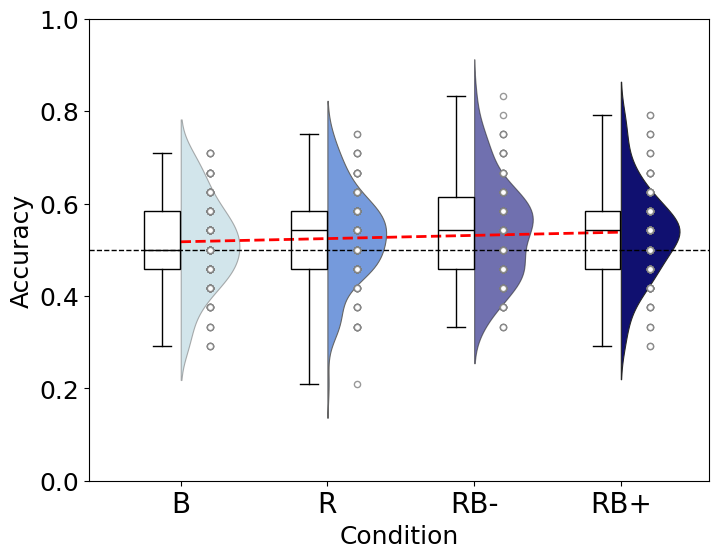

In [ ]:
# Plot with the fitted line, I should plot it with general mean accuracies, while the lmer with the raw ones

acc_tot2 = mean_acc_rule.assign(hue=1)


# Create a mapping for the ordinal encoding
condition_mapping = {'B': 1, 'R': 2, 'RB-': 3, 'RB+': 4}
condition_order = ['B', 'R','RB-','RB+']

# Reorder levels of 'condition_off' in acc_tot2
acc_tot2['condition_off'] = pd.Categorical(acc_tot2['condition_off'], categories=condition_order, ordered=True)
acc_tot2['info_index'] = acc_tot2['condition_off'].map({'B': 1, 'R': 2, 'RB-': 3, 'RB+': 4})



custom_palette = {'B': 'lightblue','R': 'cornflowerblue','RB-': 'darkblue', 'RB+':'navy' }


mean_accuracy_by_condition = acc_tot2.groupby('info_index')['accuracy'].mean().reset_index()

# Step 2: Prepare data for regression on mean accuracy by condition
X_mean = mean_accuracy_by_condition[['info_index']]
y_mean = mean_accuracy_by_condition['accuracy']

# Fit the linear regression model on mean values
model = LinearRegression()
model.fit(X_mean, y_mean)

# Create a range of values for the conditions to plot the regression line
X_range = np.linspace(1, 4, 100).reshape(-1, 1)
y_pred = model.predict(X_range)

# Initialize the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the violin plot for each condition separately with the desired color
for condition in condition_order:
    subset = acc_tot2[acc_tot2['condition_off'] == condition]
    sns.violinplot(
        data=subset,
        x='condition_off',
        y='accuracy',
        hue='hue', split=True, hue_order=[0, 1],
        palette=[custom_palette[condition], custom_palette[condition]],
        linewidth=0.8,
        inner=None,
        scale='width',
        width=0.8,
        ax=ax
    )

# Overlay the boxplot
sns.boxplot(
    data=acc_tot2,
    x='condition_off',
    y='accuracy',
    hue="hue", hue_order=[1, 0],
    palette=['black'],
    linewidth=1,
    whis=[0, 100],
    showcaps=True,
    boxprops={'facecolor': 'None', 'zorder': 10},
    showfliers=False,
    width=0.5,
    ax=ax
)

ax.legend_.remove()  # hide legend

# Set transparency for the violin plot
for violin, alpha in zip(ax.collections[::2], [0.6] * len(condition_order)):
    violin.set_alpha(alpha)

# Add scatterplot points on the right side
for i, condition in enumerate(condition_order):
    subset = acc_tot2[acc_tot2['condition_off'] == condition]
    # Adjust the x positions of the scatter points to the right side
    x_positions = np.full(subset.shape[0], i) + 0.2  # shift points to the right

    plt.scatter(
        x_positions, subset['accuracy'],
        color='white', edgecolor='grey', s=20, zorder=10, alpha=0.8
    )

    # Add the regression line
plt.plot([condition_mapping[cond] - 1 for cond in condition_order], model.predict(np.array([condition_mapping[cond] for cond in condition_order]).reshape(-1, 1)), color='red', linestyle='--', linewidth=2, label='Trend Line')


# Insert a horizontal line at y=0
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)




# Set font properties for formal font style
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18

# Set x-tick labels font size and style
plt.xticks(fontsize=20)
# Set y-tick labels font size and style
plt.yticks(fontsize=18)

# Set x-axis and y-axis labels
plt.xlabel('Condition', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)

# Set plot limits
plt.ylim(0,1)

# Set plot title
#plt.title('D-prime values rule vs violations by conditions', fontsize=20)


# Show the plot
plt.show()




### 1.2 Security rating: anova and visualizations

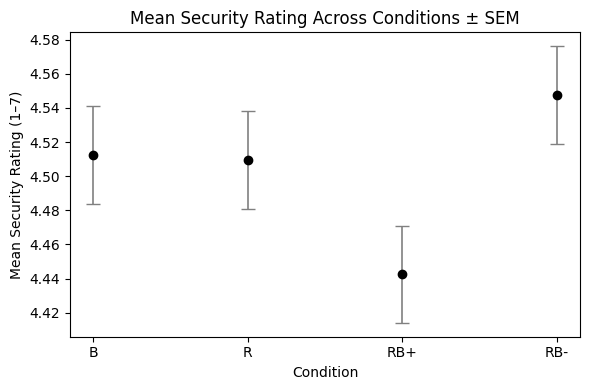

          Source         SS   DF        MS         F    p-unc       ng2  \
0  condition_off   0.685288    3  0.228429  1.298492  0.27467  0.001508   
1          Error  65.441882  372  0.175919       NaN      NaN       NaN   

        eps  
0  0.986501  
1       NaN  
Partial eta-squared: 0.010363186463372032
        Contrast    A    B  Paired  Parametric         T    dof alternative  \
0  condition_off    B    R    True        True  0.006236  124.0   two-sided   
1  condition_off    B  RB+    True        True  0.981984  124.0   two-sided   
2  condition_off    B  RB-    True        True -0.959936  124.0   two-sided   
3  condition_off    R  RB+    True        True  1.055749  124.0   two-sided   
4  condition_off    R  RB-    True        True -0.925080  124.0   two-sided   
5  condition_off  RB+  RB-    True        True -2.048695  124.0   two-sided   

      p-unc    p-corr p-adjust   BF10    hedges  
0  0.995034  0.995034   fdr_bh  0.099  0.000357  
1  0.328020  0.428065   fdr_bh  0.15

C:\Users\bianc\AppData\Local\Temp\ipykernel_6812\3452243635.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy_by_confidence2 = DATA_off.groupby(['participant','sec_rate_merged'])['accuracy'].mean().reset_index()
C:\Users\bianc\AppData\Local\Temp\ipykernel_6812\3452243635.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy_by_confidence2 = mean_accuracy_by_confidence2.groupby(['sec_rate_merged'])['accuracy'].mean().reset_index()


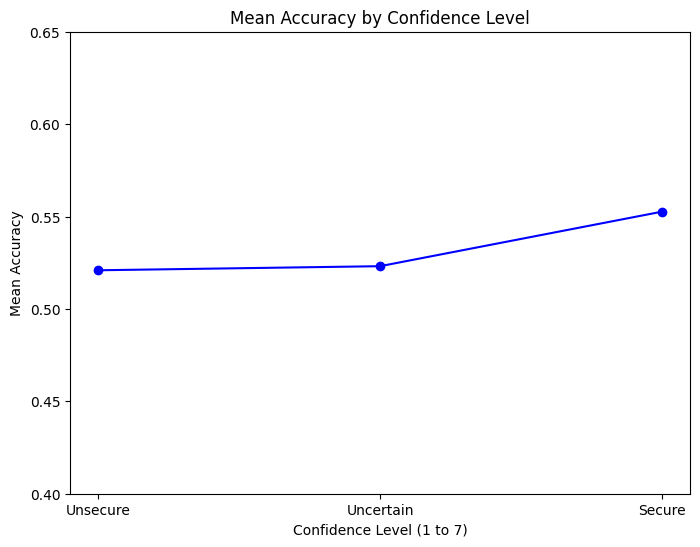

C:\Users\bianc\AppData\Local\Temp\ipykernel_6812\3452243635.py:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy_by_confidence_condition2 = DATA_off.groupby(['participant','sec_rate_merged', 'condition_off'])['accuracy'].mean().reset_index()
C:\Users\bianc\AppData\Local\Temp\ipykernel_6812\3452243635.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy_by_confidence_condition2 = mean_accuracy_by_confidence_condition2.groupby(['sec_rate_merged', 'condition_off'])['accuracy'].mean().reset_index()


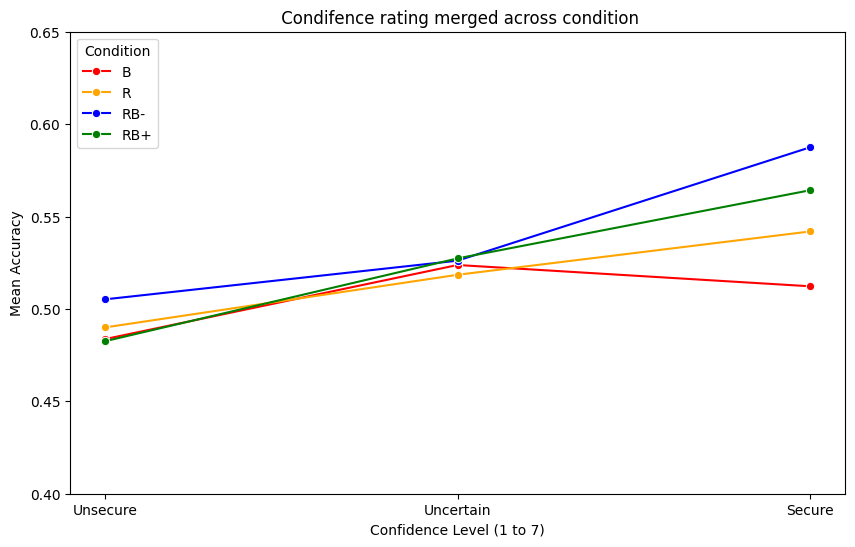

In [14]:
## Mean security reating across conditions

mean_sec_by_cond= DATA_off.groupby(['participant','condition_off'])['security_1_7.keys'].mean().reset_index()

# plot

summary_sec_rate = (
    DATA_off
    .groupby("condition_off")["security_1_7.keys"]
    .agg(['mean', 'count', 'std'])
    .reset_index()
)
summary_sec_rate["sem"] = summary_sec_rate["std"] / np.sqrt(summary_sec_rate["count"])

plt.figure(figsize=(6,4))
plt.errorbar(
    summary_sec_rate["condition_off"],
    summary_sec_rate["mean"],
    yerr=summary_sec_rate["sem"],
    fmt='o',                # 'o' = circle markers
    capsize=5, 
    color="black",
    ecolor="gray",
    elinewidth=1.2
)

plt.ylabel("Mean Security Rating (1–7)")
plt.xlabel("Condition")
plt.title("Mean Security Rating Across Conditions ± SEM")
plt.tight_layout()
plt.show()


# anova of differences across conditions


aov = pg.rm_anova(dv='security_1_7.keys', within=['condition_off'], subject='participant', data= mean_sec_by_cond, detailed=True)

print(aov)

SS_effect = aov.loc[aov['Source'] == 'condition_off', 'SS'].values[0]
SS_error  = aov.loc[aov['Source'] == 'Error', 'SS'].values[0]

# Compute partial eta squared
eta_p2 = SS_effect / (SS_effect + SS_error)
print("Partial eta-squared:", eta_p2)


# Use the updated pairwise_tests function
pwaov = pg.pairwise_tests(dv='security_1_7.keys', within=['condition_off'],
                          subject='participant', padjust='fdr_bh', data=mean_sec_by_cond,
                          interaction=True)
print(pwaov)

# create a excel writer object
with pd.ExcelWriter(output+'ANOVA_security_rating.xlsx') as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    aov.to_excel(writer, sheet_name="anova", index=False)
    pwaov.to_excel(writer, sheet_name="pirwiseTargbyCond", index=False)



# MERGE into the three gorups

## group low, medium high and plot it


mean_accuracy_by_confidence2 = DATA_off.groupby(['participant','sec_rate_merged'])['accuracy'].mean().reset_index()

mean_accuracy_by_confidence2 = mean_accuracy_by_confidence2.groupby(['sec_rate_merged'])['accuracy'].mean().reset_index()

plt.figure(figsize=(8, 6))
plt.plot(mean_accuracy_by_confidence2['sec_rate_merged'], 
         mean_accuracy_by_confidence2['accuracy'], 
         marker='o', linestyle='-', color='b')

plt.title('Mean Accuracy by Confidence Level')
plt.xlabel('Confidence Level (1 to 7)')
plt.ylabel('Mean Accuracy')
plt.grid(False)  
plt.ylim(0.4, 0.65)  

plt.show()


custom_palette = {'B': 'red','R': 'orange','RB-': 'blue', 'RB+':'green' }
condition_order = ['B', 'R', 'RB-', 'RB+']

mean_accuracy_by_confidence_condition2 = DATA_off.groupby(['participant','sec_rate_merged', 'condition_off'])['accuracy'].mean().reset_index()

mean_accuracy_by_confidence_condition2 = mean_accuracy_by_confidence_condition2.groupby(['sec_rate_merged', 'condition_off'])['accuracy'].mean().reset_index()

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=mean_accuracy_by_confidence_condition2, 
    x='sec_rate_merged', 
    y='accuracy', 
    hue='condition_off', 
    hue_order=condition_order,
    palette=custom_palette,
    marker='o'
)

sns.scatterplot(
    data=DATA_off,
    x='sec_rate_merged',
    y='accuracy',
    hue='condition_off',
    hue_order=condition_order,
    palette=custom_palette,
    edgecolor='grey',
    alpha=0.6,
    s=50,
    legend=False  
)

plt.title(' Condifence rating merged across condition')
plt.xlabel('Confidence Level (1 to 7)')
plt.ylabel('Mean Accuracy')
plt.grid(False)  
plt.ylim(0.4, 0.65) 

# Adjust legend to display in custom order and with specified title
plt.legend(title='Condition', loc='upper left')

# Show the plot
plt.show()



## 2. IMPLICIT LEARNING: Syllable detection task and security rating


#### Overview performance: of hits misses and false alarms

C:\Users\bianc\AppData\Local\Temp\ipykernel_6812\540162808.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  catches = DATA.groupby(['participant', 'condition', 'syll_to_catch']).apply(catch_count_group).reset_index()
c:\Users\bianc\miniconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\bianc\miniconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 14.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnin

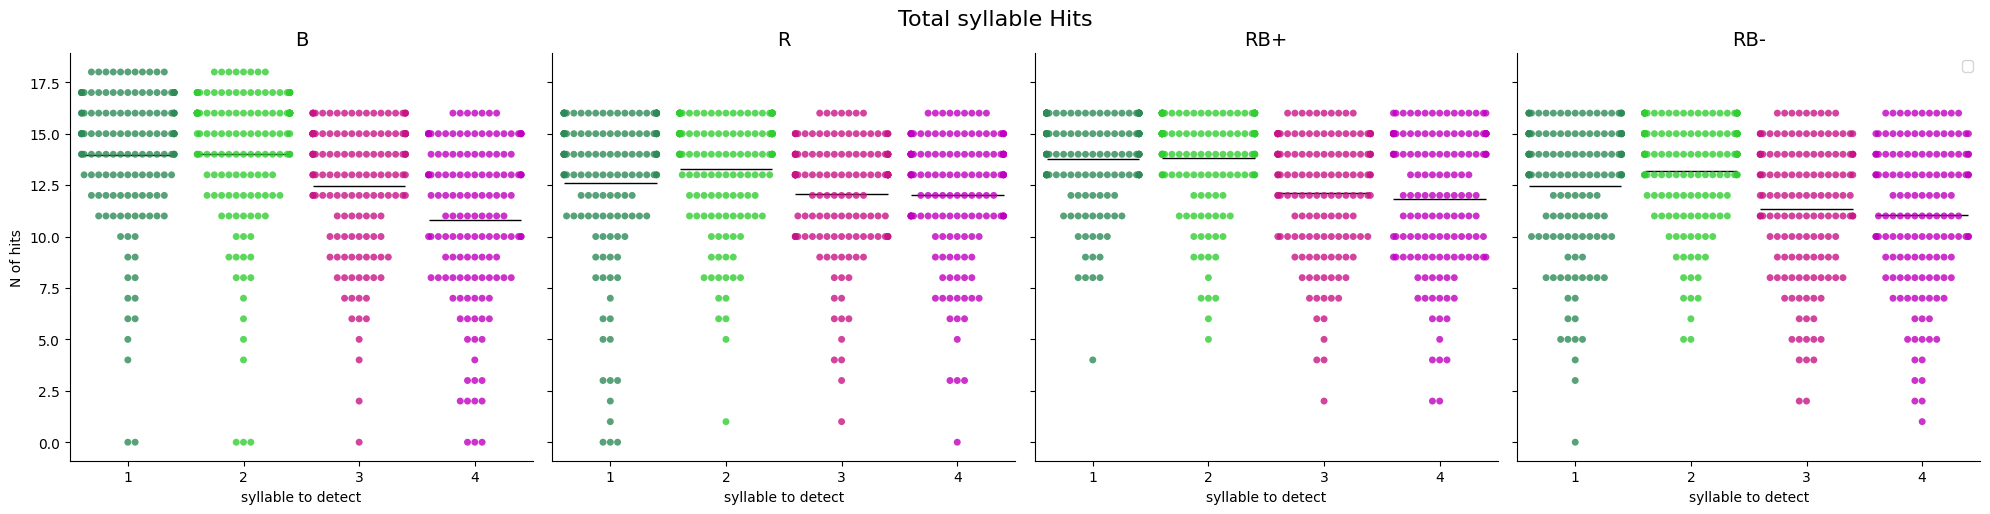

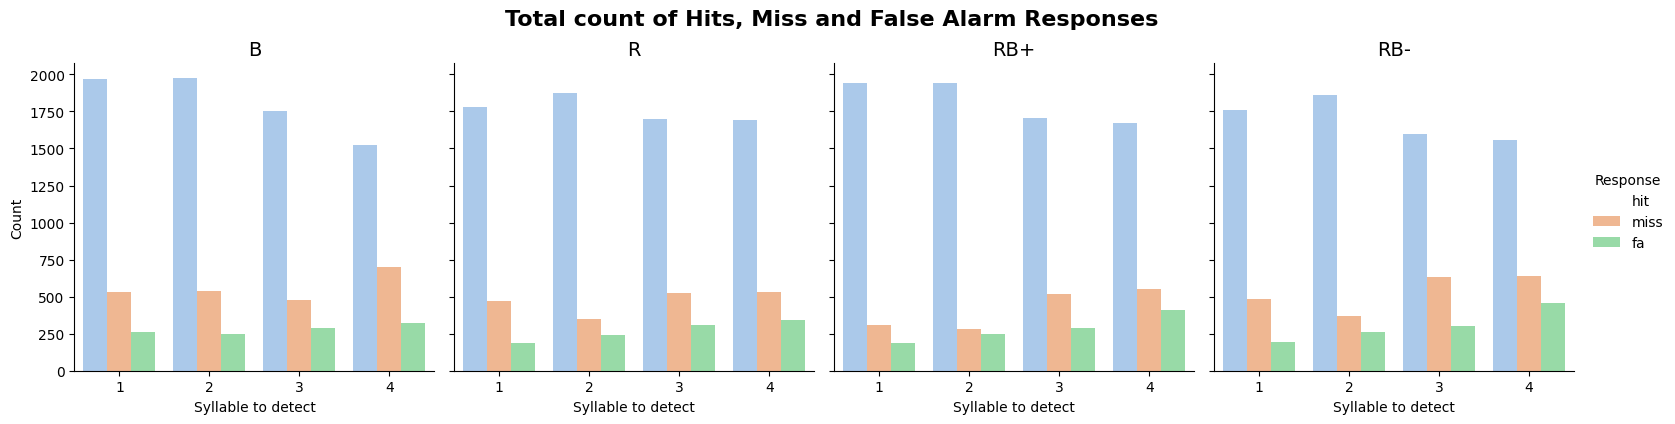

In [15]:

catches = DATA.groupby(['participant', 'condition', 'syll_to_catch']).apply(catch_count_group).reset_index()

#extract the total for each participant

catches_tot= catches.groupby(['participant', 'condition'])[['catch','miss','fa']].sum().reset_index()

# Visualize the number of hits by condition by syll to cathc

custom_palette = {'1': 'seagreen', '3': 'mediumvioletred', '4': 'm', '2': 'limegreen'}
g = sns.FacetGrid(catches, col='condition', height=5, aspect=1)  #in the col I simply put the variablle I want the data to be separated with

# Use the swarmplot to show individual data points

g.map_dataframe(sns.swarmplot, x='syll_to_catch', y='catch', alpha=0.8, palette= custom_palette) #with the g.map_dataframe we say what we want to visualize for each condition set in the col

# Use the boxplot to show the distribution with mean lines
g.map_dataframe(sns.boxplot, x='syll_to_catch', y='catch', showmeans=True,
                meanline=True, meanprops={'color': 'k', 'ls': '-', 'lw': 1},
                medianprops={'visible': False}, whiskerprops={'visible': False},
                showfliers=False, showbox=False, showcaps=False)

# Set x and y-axis labels and plot title
g.set_axis_labels('syllable to detect', 'N of hits')
g.fig.suptitle('Total syllable Hits', y=1.02, fontsize= 16)

# Add a legend to the last plot (You can change the legend position if needed)
g.axes.flat[-1].legend(loc='upper right')
# Set individual subplot titles
titles = ['B', 'R', 'RB+', 'RB-']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title, fontsize=14) #fontweight='bold')
# Show the plot
plt.show()

#2 Visualize the amount of catch, fa, miss for each syllable for each condition

catches2 = catches.groupby(['condition', 'syll_to_catch'])[['catch','miss','fa']].sum().reset_index()

# Reshape the dataframe to a long format
df_melted = pd.melt(catches2, id_vars=['condition', 'syll_to_catch'], value_vars=['catch', 'miss', 'fa'],
                    var_name='response', value_name='count')


# Define the order of responses for proper sorting in the plot
response_order = ['catch', 'miss', 'fa']

# Create the FacetGrid
g = sns.FacetGrid(df_melted, col='condition', height=4, aspect=1, sharex=False)

# Use barplot to plot the counts of responses within each internal condition
g.map_dataframe(sns.barplot, x='syll_to_catch', y='count', hue='response', palette='pastel', order=[1, 2, 3, 4], hue_order=response_order)
g.set_axis_labels('Syllable to detect', 'Count')
g.fig.suptitle('Total count of Hits, Miss and False Alarm Responses', y=1.05, fontsize=16, fontweight='bold')
titles = ['B', 'R', 'RB+', 'RB-']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title, fontsize=14) #fontweight='bold')
# Show the plot
# Adjust the plot appearance
g.add_legend(title='Response', label_order=['hit', 'miss', 'fa'])
#g.set_titles('Main Condition: {row_name}')

# Show the plot
plt.show()

#### Dataframe preparation and save for R model analysis

In [16]:
# Find the start and end indices of the desired columns
# List of all columns


RTsall=DATA[['participant', 'expName', 'group', 'age', 'sex', 'hand', 'education_level','condition', 'block', 'language',
             'rule structure online','trial_online','s1', 's2', 's3', 's4', 's5', 's6', 's7', 
             's8', 's9', 's10', 's11', 'time_syll', 'catch_syll_resp','beat_no_beat','syll_to_catch',
             'order_trial_on','catch_rtsTR', 'BMRQ_score', 'music_exp', 'mus_exp_age','n_lang', 'n_lang_used', 'ability_learn_l2', 
             'tendence_mix_lan', 'partiture', 'music_use']]


#RTsall=RTsall.dropna(how='any')

#Again, I will do this once I set a proper exclusion critieria
common_rows = pd.merge(RTsall, catches_toexclude, on=['participant', 'condition'], how='inner')


#it is important if I want to do this they must be indexed based on the common values 

RTsall.set_index(['participant','condition'], inplace=True)
common_rows.set_index(['participant', 'condition'], inplace=True)

# Drop common rows from RTs
RTsall= RTsall.drop(common_rows.index).reset_index()



#add the accuracy of the hit rate during the online as a furhter possible predicotr

#next extract the hit rate of overLL syllables during the online task (measur whether attention during the task impacted)

hits_accuracy_ON= catches_clean.groupby(['participant', 'condition'])['catch'].sum().reset_index()

accr_hit=[]

for i in range(len(hits_accuracy_ON)):
    cond= hits_accuracy_ON['condition'].iloc[i]
    if cond == 'B':
        accr= hits_accuracy_ON['catch'].iloc[i]/68 #the when condition has some exposition more to allow full coutnerbalancing of order
    if cond != 'B':
        accr= hits_accuracy_ON['catch'].iloc[i]/64
    accr_hit.append(accr)

hits_accuracy_ON['acc_hit']=accr_hit



#now insert it in the DATA_off

RTsall= pd.merge(RTsall, hits_accuracy_ON, on=['participant', 'condition'], how='inner').reset_index()


#rename the conditions

RTsall= rename_cond(RTsall, 'condition')

RTsall= syllable_order(RTsall, 'time_syll')      

RTsall= rename_sylls(RTsall)


# Create a mapping for the ordinal encoding
condition_mapping = {'B': 1, 'R': 2, 'RB-': 3, 'RB+': 4}

# Apply the mapping to create a numeric encoding of the conditions
RTsall['info_index'] = RTsall['condition'].map(condition_mapping)


RTsall['syll_to_catch2']= RTsall['syll_to_catch'].replace({1: 'A', 2: 'C', 3: 'X1', 4:'X2'})

RTsall = RTsall.dropna(subset=['catch_rtsTR'])

#some problems with numbers of age and lang used fix them this way

RTsall.to_csv(dataframes_R_analysis+'ImplicitTestData.csv') 

### 2.1 RTS

#### Preliminary analysis interaction condition x target: Anovas 2x2 with X1 and X2 separated

c:\Users\bianc\miniconda3\Lib\site-packages\pingouin\distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(
c:\Users\bianc\miniconda3\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)


eta p (condition): 0.01971518652773924
eta p (syll_to_catch2): 0.18210848200635366
 eta p (interaction): 0.02362230773349363
                      Contrast condition    A    B Paired Parametric  \
0                    condition         -    B    R   True       True   
1                    condition         -    B  RB+   True       True   
2                    condition         -    B  RB-   True       True   
3                    condition         -    R  RB+   True       True   
4                    condition         -    R  RB-   True       True   
5                    condition         -  RB+  RB-   True       True   
6               syll_to_catch2         -    A    C   True       True   
7               syll_to_catch2         -    A   X1   True       True   
8               syll_to_catch2         -    A   X2   True       True   
9               syll_to_catch2         -    C   X1   True       True   
10              syll_to_catch2         -    C   X2   True       True   
11         

c:\Users\bianc\miniconda3\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)


                      Contrast syll_to_catch2    A    B Paired Parametric  \
0               syll_to_catch2              -    A    C   True       True   
1               syll_to_catch2              -    A   X1   True       True   
2               syll_to_catch2              -    A   X2   True       True   
3               syll_to_catch2              -    C   X1   True       True   
4               syll_to_catch2              -    C   X2   True       True   
5               syll_to_catch2              -   X1   X2   True       True   
6                    condition              -    B    R   True       True   
7                    condition              -    B  RB+   True       True   
8                    condition              -    B  RB-   True       True   
9                    condition              -    R  RB+   True       True   
10                   condition              -    R  RB-   True       True   
11                   condition              -  RB+  RB-   True       True   

c:\Users\bianc\miniconda3\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   B_A    B_C  -0.0024    1.0 -0.0245  0.0197  False
   B_A   B_X1   -0.005    1.0 -0.0278  0.0177  False
   B_A   B_X2  -0.0023    1.0  -0.026  0.0214  False
   B_A  RB+_A  -0.0236 0.0241 -0.0458 -0.0014   True
   B_A  RB+_C  -0.0384    0.0 -0.0604 -0.0163   True
   B_A RB+_X1   0.0059    1.0  -0.017  0.0288  False
   B_A RB+_X2   0.0027    1.0 -0.0204  0.0258  False
   B_A  RB-_A  -0.0074 0.9993 -0.0303  0.0155  False
   B_A  RB-_C  -0.0367    0.0 -0.0592 -0.0142   True
   B_A RB-_X1   0.0172 0.4765 -0.0064  0.0408  False
   B_A RB-_X2   0.0014    1.0 -0.0224  0.0253  False
   B_A    R_A   0.0008    1.0 -0.0219  0.0236  False
   B_A    R_C  -0.0288 0.0011 -0.0511 -0.0065   True
   B_A   R_X1   0.0106  0.973 -0.0124  0.0336  False
   B_A   R_X2   0.0005    1.0 -0.0225  0.0235  False
   B_C   B_X1  -0.0026    1.0 -0.0254  0.0201 

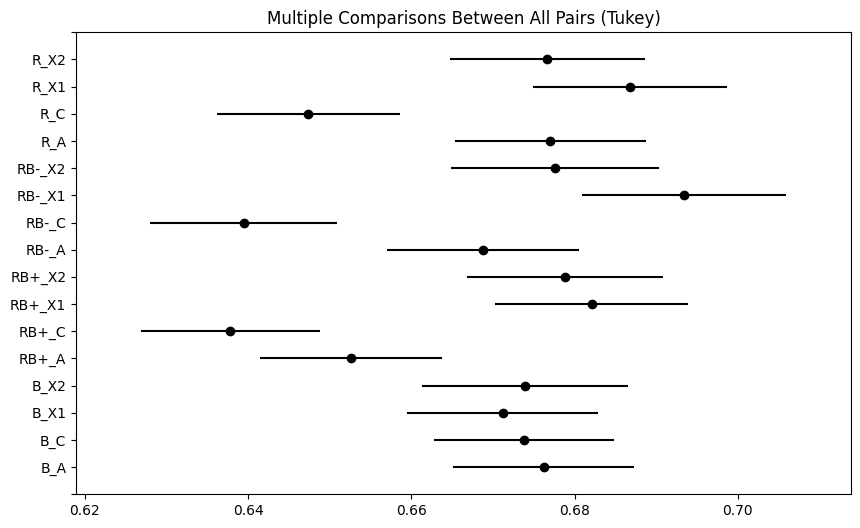

In [ ]:

#pairwise anova on syll and condition

RTsall['participant'] = RTsall['participant'].astype(str)
RTsall['condition'] = RTsall['condition'].astype(str)
RTsall['syll_to_catch2'] = RTsall['syll_to_catch2'].astype(str)
RTsall['catch_rtsTR'] = RTsall['catch_rtsTR'].astype(float)
#Anovas 2x2

aov = pg.rm_anova(dv='catch_rtsTR', within=['condition', 'syll_to_catch2'], subject='participant', data= RTsall, detailed=True)

#get partial eta swquared for effect size

eta_p2_condition = partial_eta_sq(aov, 'condition')
eta_p2_syll      = partial_eta_sq(aov, 'syll_to_catch2')
eta_p2_inter     = partial_eta_sq(aov, 'condition * syll_to_catch2')

print("eta p (condition):", eta_p2_condition)
print("eta p (syll_to_catch2):", eta_p2_syll)
print(" eta p (interaction):", eta_p2_inter)

# Use the updated pairwise_tests function
pwaov = pg.pairwise_tests(dv='catch_rtsTR', within=['condition', 'syll_to_catch2'],
                          subject='participant', padjust='fdr_bh', data=RTsall,
                          interaction=True)
print(pwaov)

# Use the updated pairwise_tests function
pwaov2 = pg.pairwise_tests(dv='catch_rtsTR', within=['syll_to_catch2','condition'],
                          subject='participant', padjust='fdr_bh', data=RTsall,
                          interaction=True)
print(pwaov2)


# create a excel writer object
with pd.ExcelWriter(output+'2x2RTsANOVA.xlsx') as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    aov.to_excel(writer, sheet_name="anova_2x2", index=False)
    pwaov.to_excel(writer, sheet_name="pairwiseCondbyTarg", index=False)
    pwaov2.to_excel(writer, sheet_name="pirwiseTargbyCond", index=False)



# Combine 'condition' and 'target_syllable' into a single factor
RTsall['combined'] = RTsall['condition'] + '_' + RTsall['syll_to_catch2']

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=RTsall['catch_rtsTR'], groups=RTsall['combined'], alpha=0.05)
print(tukey)
# Convert Tukey HSD results to DataFrame
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# To visualize the results
tukey.plot_simultaneous()
plt.show()


#### Exploration of RB- condition (difference X1 and X2): T-test excluding beat effect

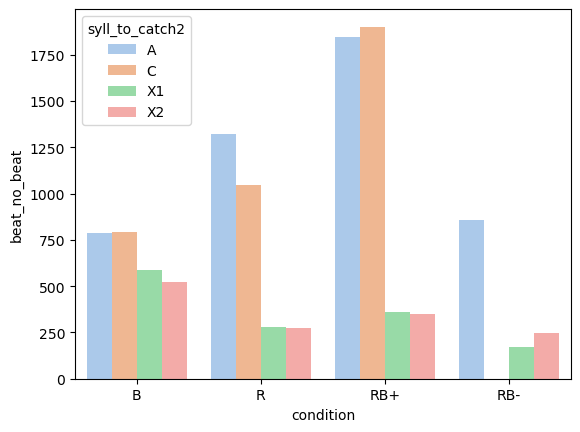

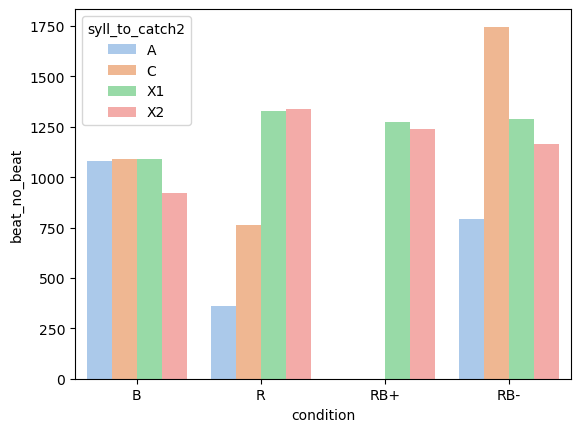

Paired t-test results considering only RB- X1 and X2 :
T-statistic = 1.602, p-value = 0.111


In [ ]:
# The initial anova 2x2 condition x target showed presence of difference acress X1 and X2 in RB-
# subcessive analysis showed presence of a big difference in the occurrence of X2 in RB-
# as happening in a on-beat position. Therefore we re-executed the anova only considering the
# non beat-convergent x syllables (the vast majority). The results suggest the original difference
# was actually driven by this imbalance

# barplot to explore effect x1 vs x2 in the RB-: Evidence that there are more on beat than not on beat for the X2 as compared to the X1


RTscount= RTsall[RTsall['beat_no_beat']== 'beat'].groupby(['condition', 'syll_to_catch2'])['beat_no_beat'].count().reset_index()



# Use barplot to plot the counts of responses within each internal condition
sns.barplot ( x='condition', y='beat_no_beat', data= RTscount, hue='syll_to_catch2', palette='pastel')

plt.show()

RTscount2= RTsall[RTsall['beat_no_beat']== 'no_beat'].groupby(['condition', 'syll_to_catch2'])['beat_no_beat'].count().reset_index()

# Use barplot to plot the counts of responses within each internal condition
sns.barplot ( x='condition', y='beat_no_beat', data= RTscount2, hue='syll_to_catch2', palette='pastel')

plt.show()

#do a pairwise t.test across X1 and X2 in RB- excluding the on-beat observations

RBmin_x1_x2 = RTsall[(RTsall['condition'] == 'RB-') & (RTsall['syll_to_catch2'].isin(['X1', 'X2'])) & (RTsall['beat_no_beat'] == 'no_beat')]

RBmin_x1x2_mean= RBmin_x1_x2.groupby(['participant', 'syll_to_catch2'])[['catch_rtsTR']].mean().reset_index()

# Pivot to get separate columns for X1 and X2
RBmin_x1x2_pivot = RBmin_x1x2_mean.pivot(index='participant', columns='syll_to_catch2', values='catch_rtsTR')

# Rename columns for clarity
RBmin_x1x2_pivot.columns = ['RT_x1', 'RT_x2']

# Drop NaN rows (if any participants have missing values for either X1 or X2)
RBmin_x1x2_pivot = RBmin_x1x2_pivot.dropna()

# Perform paired t-test
t_stat, p_value = stats.ttest_rel(RBmin_x1x2_pivot['RT_x1'], RBmin_x1x2_pivot['RT_x2'])

# Display results
print(f"Paired t-test results considering only RB- X1 and X2 :\nT-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")


#### Anovas 2x2 with X1 and X2 MERGED

c:\Users\bianc\miniconda3\Lib\site-packages\pingouin\distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(
c:\Users\bianc\miniconda3\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)


                       Source        SS  ddof1  ddof2        MS          F  \
0                   condition  0.068594      3    360  0.022865   3.929483   
1              syll_to_catch2  0.211137      2    240  0.105569  40.736335   
2  condition * syll_to_catch2  0.074769      6    720  0.012462   3.424249   

          p-unc     p-GG-corr       ng2       eps  
0  8.822941e-03  9.795290e-03  0.003189  0.959363  
1  5.862222e-16  1.243205e-15  0.009752  0.975794  
2  2.434603e-03  6.371180e-03  0.003475  0.752715  
                      Contrast condition    A    B Paired Parametric  \
0                    condition         -    B    R   True       True   
1                    condition         -    B  RB+   True       True   
2                    condition         -    B  RB-   True       True   
3                    condition         -    R  RB+   True       True   
4                    condition         -    R  RB-   True       True   
5                    condition         -  RB+  

c:\Users\bianc\miniconda3\Lib\site-packages\pingouin\pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)


                      Contrast syll_to_catch2    A    B Paired Parametric  \
0               syll_to_catch2              -    A    C   True       True   
1               syll_to_catch2              -    A    X   True       True   
2               syll_to_catch2              -    C    X   True       True   
3                    condition              -    B    R   True       True   
4                    condition              -    B  RB+   True       True   
5                    condition              -    B  RB-   True       True   
6                    condition              -    R  RB+   True       True   
7                    condition              -    R  RB-   True       True   
8                    condition              -  RB+  RB-   True       True   
9   syll_to_catch2 * condition              A    B    R   True       True   
10  syll_to_catch2 * condition              A    B  RB+   True       True   
11  syll_to_catch2 * condition              A    B  RB-   True       True   

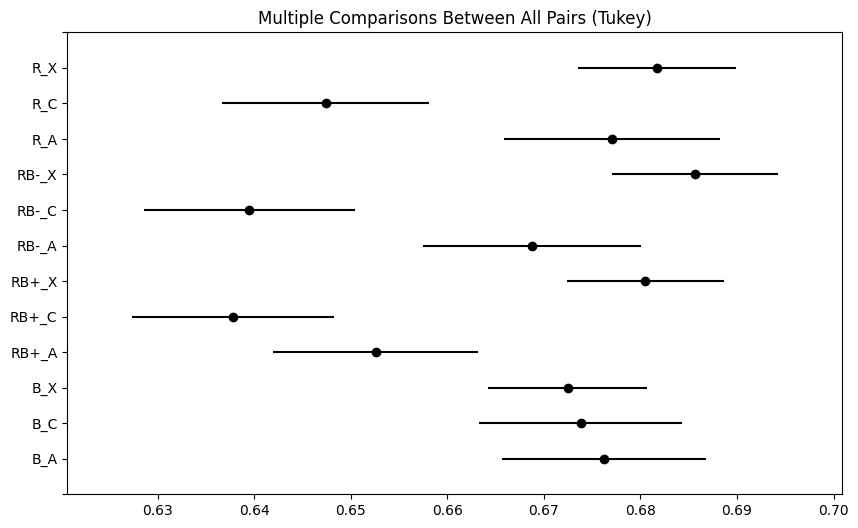

In [19]:
#anova with merged X sylls

RTsX= RTsall.copy()
RTsX['syll_to_catch2']= RTsX['syll_to_catch2'].replace({'X1': 'X', 'X2': 'X'})

aov = pg.rm_anova(dv='catch_rtsTR', within=['condition', 'syll_to_catch2'], subject='participant', data= RTsX, detailed=True)

print(aov)
# Use the updated pairwise_tests function
pwaov = pg.pairwise_tests(dv='catch_rtsTR', within=['condition', 'syll_to_catch2'],
                          subject='participant', padjust='fdr_bh', data=RTsX,
                          interaction=True)
print(pwaov)


eta_p2_condition = partial_eta_sq(aov, 'condition')
eta_p2_syll      = partial_eta_sq(aov, 'syll_to_catch2')
eta_p2_inter     = partial_eta_sq(aov, 'condition * syll_to_catch2')

print("eta p (condition):", eta_p2_condition)
print("eta p (syll_to_catch2):", eta_p2_syll)
print(" eta p (interaction):", eta_p2_inter)


# Use the updated pairwise_tests function
pwaov2 = pg.pairwise_tests(dv='catch_rtsTR', within=['syll_to_catch2','condition'],
                          subject='participant', padjust='fdr_bh', data=RTsX,
                          interaction=True)
print(pwaov2)

# create a excel writer object
with pd.ExcelWriter(output+'2x2RTsANOVA_Xmerged.xlsx') as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    aov.to_excel(writer, sheet_name="anova_2x2", index=False)
    pwaov.to_excel(writer, sheet_name="pairwiseCondbyTarg", index=False)
    pwaov2.to_excel(writer, sheet_name="pirwiseTargbyCond", index=False)

print(aov)

# Combine 'condition' and 'target_syllable' into a single factor
RTsX['combined'] = RTsX['condition'] + '_' + RTsX['syll_to_catch2']

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=RTsX['catch_rtsTR'], groups=RTsX['combined'], alpha=0.05)
print(tukey)
# Convert Tukey HSD results to DataFrame
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# To visualize the results
tukey.plot_simultaneous()
plt.show()


#### T-test General beat effect

Length of RTsbeat: 141
Length of Rts_nobeat: 141
T-statistic: -2.069210152765983
P-value: 0.04036525456677184


C:\Users\bianc\AppData\Local\Temp\ipykernel_6812\1981404764.py:33: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(
C:\Users\bianc\AppData\Local\Temp\ipykernel_6812\1981404764.py:50: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax= sns.violinplot(


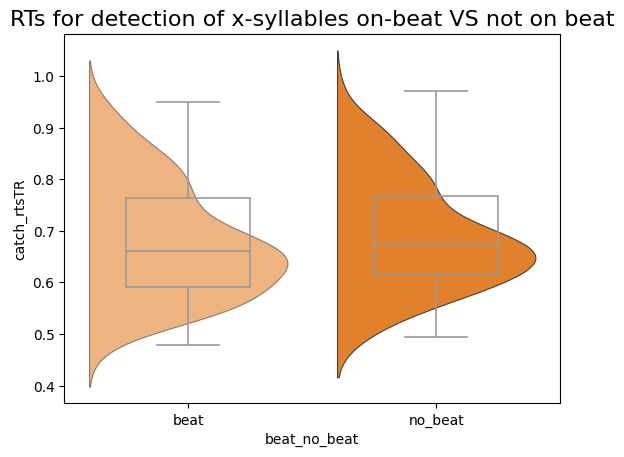

In [20]:

#only isolate the x syllables on beat and not on beat. I had to work on mean values as those on beat were wau less in number as compared to those not on beat

RTsbeat_effect=  RTsall[(RTsall['condition']!= 'R' ) & ((RTsall['syll_to_catch']== 3) | (RTsall['syll_to_catch']== 4))]


# Group by participant and beat/no_beat, then calculate mean reaction times
mean_rts = RTsbeat_effect.groupby(['participant', 'beat_no_beat'])['catch_rtsTR'].mean().reset_index()

# Pivot the table to have beat and no_beat as columns
mean_rts_pivot = mean_rts.pivot(index='participant', columns='beat_no_beat', values='catch_rtsTR').reset_index()

# Drop participants with missing data
mean_rts_pivot = mean_rts_pivot.dropna()

# Extract the mean reaction times for beat and no_beat conditions
RTsbeat = mean_rts_pivot['beat']
Rts_nobeat = mean_rts_pivot['no_beat']

# Check the lengths to ensure they match
print("Length of RTsbeat:", len(RTsbeat))
print("Length of Rts_nobeat:", len(Rts_nobeat))

# Perform paired t-test
t_stat, p_value = stats.ttest_rel(RTsbeat, Rts_nobeat)

print("T-statistic:", t_stat)
print("P-value:", p_value)

mean_rts2=mean_rts.assign(hue=1)
# Adjusted visualization: Reaction times across different syllables and conditions

# Plot the boxplot on top of the violin plot with reduced width
sns.boxplot(
    data=mean_rts2,
    x='beat_no_beat',
    y='catch_rtsTR',
    hue= "hue",hue_order=[1,0],
    palette=['white'],
    linewidth=1.2,  # Adjust the boxplot line width
    whis=[0, 100],  # Show the full range of the data
    showcaps=True,  # Show the caps
    boxprops={'facecolor': 'None', 'zorder': 10},  # Make boxplot fill transparent and bring to front
    showfliers=False,  # Do not show outliers again, as they are already shown in the violin plot
    width=0.5  # Reduce the width of the boxplots
)



# Plot the violin plot with transparency and reduced width
ax= sns.violinplot(
    data=mean_rts2,
    x='beat_no_beat',
    y='catch_rtsTR',
    hue="hue", split=True, hue_order=[0,1],#this to see half and half
    #palette=['limegreen', 'darkgreen','darkcyan','royalblue'],
    linewidth=0.8,  # Reduce the contour line width
    inner=None,  # Disable the inner bars
    scale='width',  # Scale to the same width
    width=0.8,  # Reduce the width of the violins
)


ax.legend_.remove() # hide legend
# Set transparency for the violin plot

for violin, alpha in zip(ax.collections[::2], [0.6,0.6,0.6,0.6]):
    violin.set_alpha(alpha)

plt.title('RTs for detection of x-syllables on-beat VS not on beat', fontsize= 16)

plt.show()



####  ANOVA only X syllable condition x target: absence of differences across X

In [29]:
#anova with merged X sylls

RTsX= RTsall.copy()
RTsX['syll_to_catch2']= RTsX['syll_to_catch2'].replace({'X1': 'X', 'X2': 'X'})

X_only= RTsX[RTsX['syll_to_catch2']=='X']

aov = pg.rm_anova(dv='catch_rtsTR', within=['condition'], subject='participant', data= X_only, detailed=True)

print(aov)



SS_effect = aov.loc[aov['Source'] == 'condition', 'SS'].values[0]
SS_error  = aov.loc[aov['Source'] == 'Error', 'SS'].values[0]

# Compute partial eta squared
eta_p2 = SS_effect / (SS_effect + SS_error)
print("Partial eta-squared:", eta_p2)


# Use the updated pairwise_tests function
pwaov = pg.pairwise_tests(dv='catch_rtsTR', within=['condition'],
                          subject='participant', padjust='fdr_bh', data=X_only,
                          interaction=True)
print(pwaov)


# create a excel writer object
with pd.ExcelWriter(output+'RTsANOVA_X_by_condition.xlsx') as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    aov.to_excel(writer, sheet_name="anova", index=False)
    pwaov.to_excel(writer, sheet_name="pairwiseCondbyTarg", index=False)

print(aov)



      Source        SS   DF        MS         F     p-unc       ng2       eps
0  condition  0.004111    3  0.001370  0.438239  0.725774  0.000656  0.965907
1      Error  1.163113  372  0.003127       NaN       NaN       NaN       NaN
Partial eta-squared: 0.0035217360971916242
    Contrast    A    B  Paired  Parametric         T    dof alternative  \
0  condition    B    R    True        True -0.987655  124.0   two-sided   
1  condition    B  RB+    True        True -0.821557  124.0   two-sided   
2  condition    B  RB-    True        True -0.737431  124.0   two-sided   
3  condition    R  RB+    True        True  0.326713  124.0   two-sided   
4  condition    R  RB-    True        True  0.377642  124.0   two-sided   
5  condition  RB+  RB-    True        True  0.069455  124.0   two-sided   

      p-unc    p-corr p-adjust   BF10    hedges  
0  0.325245  0.893323   fdr_bh   0.16 -0.068680  
1  0.412906  0.893323   fdr_bh  0.138 -0.050304  
2  0.462253  0.893323   fdr_bh   0.13 -0.046496

### 2.2 Rule Predictability Index (RPI)

#### Extraction of indeces and save for R modeling

In [21]:
#create a code that isolates for each condition and participant: mean RTs to X not on beat; difference of mean RTs to X on beat minus normal X; difference mean X not on beat and RUle A; difference mean X not on beat and RUle B; 

RTsall['syll_to_catch2'] = RTsall['syll_to_catch2'].replace({'X1': 'X', 'X2': 'X'})

RTs= RTsall.copy()

vars_of_int= ['participant', 'condition', 'expName', 'group', 'age', 'sex', 'hand', 'education_level',
              'block', 'language', 'BMRQ_score', 'music_exp', 'n_lang', 'n_lang_used', 'ability_learn_l2', 
              'tendence_mix_lan', 'partiture', 'music_use']


baseline = RTsall[(RTsall['syll_to_catch2'].isin(['X'])) & (RTsall['beat_no_beat'] == 'no_beat')].groupby(vars_of_int)['catch_rtsTR'].mean().reset_index()

beat_effect=RTsall[(RTsall['syll_to_catch2'].isin(['X'])) & (RTsall['beat_no_beat']=='beat')].groupby(vars_of_int)['catch_rtsTR'].mean().reset_index()

#rule A

rule_A= RTsall[(RTsall['syll_to_catch2']=='A')].groupby(vars_of_int)[['catch_rtsTR']].mean().reset_index()


#rule C

rule_C= RTsall[(RTsall['syll_to_catch2']=='C')].groupby(vars_of_int)[['catch_rtsTR']].mean().reset_index()


# Merge the dataframes
merged_df = baseline.merge(beat_effect, on=vars_of_int, suffixes=('_baseline', '_beat_effect'))
merged_df = merged_df.merge(rule_A, on=vars_of_int)
RTs_effect = merged_df.merge(rule_C, on=vars_of_int, suffixes=('_rule_A', '_rule_C'))


# Creating the dictionary for renaming columns
rename_dict = {
    'catch_rtsTR_baseline': 'baseline',
    'catch_rtsTR_beat_effect': 'beat_only',
    'catch_rtsTR_rule_A': 'ruleA',
    'catch_rtsTR_rule_C': 'ruleC'
}

# Applying the renaming to the DataFrame
RTs_effect = RTs_effect.rename(columns=rename_dict)

#create the dataframe where I can extract the differences

RTsEff= RTs_effect.copy()
beat_eff=[]
ruleA_eff=[]
ruleC_eff=[]

# here is the caluclation of the rule predictavility index, subtracting the baseline mean RTs of each participant to the mean C, A and Beat. The bigger the difference the faster in the target

for i in range(len(RTsEff)):
    BS= RTsEff['baseline'].iloc[i]
    beat=RTsEff['beat_only'].iloc[i]
    rA=RTsEff['ruleA'].iloc[i]
    rC=RTsEff['ruleC'].iloc[i]
    beat_eff.append(BS-beat)
    ruleA_eff.append(BS-rA)
    ruleC_eff.append(BS-rC)

RTsEff['beat_eff']=beat_eff
RTsEff['rA_eff']=ruleA_eff
RTsEff['rC_eff']= ruleC_eff


columns_to_drop = ['baseline', 'beat_only', 'ruleA', 'ruleC']

# Dropping the columns
RTsEff = RTsEff.drop(columns=columns_to_drop)

# Reshape the data into long format
RTsEff = pd.melt(RTsEff, id_vars=vars_of_int, value_vars=['beat_eff', 'rA_eff', 'rC_eff'],var_name='effect', value_name='meanRTs')

RTsrule= RTsEff.copy()


# Keep both rule-related effects: rA_eff and rC_eff
RTsrule = RTsEff[RTsEff['effect'].isin(['rA_eff', 'rC_eff'])].copy()

# Map effect to syllable label
syllable_mapping = {'rA_eff': 'A', 'rC_eff': 'C'}
RTsrule['syllable'] = RTsrule['effect'].map(syllable_mapping)

# Map condition to ordinal info_index
condition_mapping = {'B': 1, 'R': 2, 'RB-': 3, 'RB+': 4}
RTsrule['info_index'] = RTsrule['condition'].map(condition_mapping)

# Clean and reorder
RTsrule = RTsrule.sort_values(by=['info_index', 'participant', 'meanRTs'])
RTsrule.reset_index(drop=True, inplace=True)

RTsrule.drop(columns='effect', inplace=True)


# Check the ordered dataframe
print(RTsrule.head())

RTsrule.to_csv(dataframes_R_analysis+'RPIs.csv') #comment it becuase some problems in coversion for age (had to manually insert some numbers because R was not reading them correctly)



  participant condition              expName group   age        sex   hand  \
0        s154         B      Experiment4_uns     A  25.0  masculino  right   
1        s154         B      Experiment4_uns     A  25.0  masculino  right   
2         102         B  Unsyncopated_study2     B  23.0   feminino  right   
3         102         B  Unsyncopated_study2     B  23.0   feminino  right   
4         157         B      Experiment4_uns     A  24.0   feminino  right   

   education_level  block language  ...  music_exp n_lang  n_lang_used  \
0  Bachelor degree      3       L2  ...         no    2.0          2.0   
1  Bachelor degree      3       L2  ...         no    2.0          2.0   
2    Master degree      1       L4  ...         no    2.0          2.0   
3    Master degree      1       L4  ...         no    2.0          2.0   
4    Master degree      1       L2  ...        yes    3.0          2.0   

   ability_learn_l2  tendence_mix_lan  partiture music_use   meanRTs  \
0             